# AnyoneAI - Project I : An analysis of NBA players in the 2021/2022 season

We want to create a DataFrame contsining information about all active players in the current NBA season, with the following structure:


| Personal Information |Player career statistics | Misc |
|   :---:    |   :---:   |   :---:   |
| player_id (int) (INDEX) | games played (int) | salary in US$(int) (this season only) |
| player_name (str) | minutes per game (float) | |
| team_name (str) | points per game (float) | |
| position (str) | rebounds per game (float) | |
| height (int) (in centimeters) | assists per game (float) | |
| weight (float) (in kilograms) |steals per game (float) | |
| country of origin (str) |blocks per game (float) | |
| date_of_birth (datetime) | | |
| age (str) (years and months) | | |
| years_of_experience (int) (years since entering the league) | | |
| Draft position (int) | | |


# Collecting information for building the dataset.

You can use any public and free API you can find, providing the code that gets that information. We recommend using this API:
 
- https://github.com/swar/nba_api

    This is a Python library that can be used to obtain data from stats.nba.com, it provides a set of methods that abstracts you from making the http calls, but directly makes calls to nba stats page and parses the results. [Here](https://github.com/swar/nba_api/blob/master/docs/examples/Basics.ipynb) are a couple of examples on how to use it. There is also a [tutorial](https://www.youtube.com/watch?v=a3u-3gEYvxM).    

- Try to get all the required information for 1 player, read the APIs documentation carefuly, then think about how to use them to collect all players data. 

- The most public APIs have some kind of rate limit, be careful about iterating on data and making lots of requests in a short amount of time (a 1 second delay between calls should be enough).

- We only want data about players that have played in the current season.

- You're not going to find the player contract information in both of those APIs: . Use the "contracts.csv" that is provided to you.

## About the imports and the IDE

If we run the notebook in Colab, some modules have to be imported each time. Also we have to mount the notebook on the drive folder, so below we authomatize all of that.

We also get the appropriate path for whichever environment we are working on.

In [1]:
import os

if 'google.colab' in str(get_ipython()):
  # The -q key in pip is to not showcase all the importing module.
  # It is risky because you may not get error messages, but in this case it is to save time and space 
  # when running the notebook in Colaboratory.
  !pip install nba_api -q
  !pip install unidecode -q
  !pip install --upgrade geopandas -q
  print('nba_api, unidecode installed')
  from google.colab import drive
  drive.mount('/content/drive')

  path = '/content/drive/My Drive/python_estudiando/' 
  import sys
  sys.path.insert(0,path)
else:
  print('Not running on CoLab')
  path = os.getcwd()+"/"

     |████████████████████████████████| 125 kB 7.5 MB/s 
     |████████████████████████████████| 235 kB 7.0 MB/s 
     |████████████████████████████████| 1.0 MB 8.3 MB/s 
     |████████████████████████████████| 6.3 MB 31.8 MB/s 
     |████████████████████████████████| 16.7 MB 313 kB/s 
nba_api, unidecode installed
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from time import sleep
from math import ceil

from dateutil import relativedelta
from datetime import datetime, date
from unidecode import unidecode

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats, commonallplayers, commonplayerinfo

import geopandas as gpd
from descartes import PolygonPatch

1.1- Create a function to find all ACTIVE players, meaning players that are listed with a team in the 2021/2022 season. For now you only need the player id, name, and team. Save the dataframe to a csv named "nba_current_players_list.csv". The function should return the dataframe.

Consider dropping: 
- All players with TEAM_ID == 0
- All players with GAMES_PLAYED_FLAG == N
- Players with id 1630597 & 1630492 (These guys are a problem ;))

In [ ]:
def get_and_save_players_list():
  data= commonallplayers.CommonAllPlayers(season='2021-22')
  df = data.get_data_frames()[0]
  df = df.loc[df.GAMES_PLAYED_FLAG != "N"].loc[df.TEAM_ID != 0].loc[~df.PERSON_ID.isin([1630597, 1630492])]
  return df

current_players_list = get_and_save_players_list()
current_players_list.to_csv(path+"nba_current_players_list.csv", index = False)

In [ ]:
if current_players_list.shape == (503, 16):
    print('Success!')
else:
    raise ValueError('The shape is incorrect, please review your function')

Success!


1.2- Create a function to find the personal information of all players listed in the dataframe created in the previous step, and save it to a csv file named "nba_players_personal_info.csv". The function should also return the created dataframe.

In [ ]:
def get_players_personal_information():
  current_players_list = pd.read_csv(path+"nba_current_players_list.csv")
  df = pd.DataFrame()

  for index, row in current_players_list.iterrows():
    data= commonplayerinfo.CommonPlayerInfo(player_id = str(row.PERSON_ID))
    data = data.get_data_frames()[0]
    df = pd.concat([df, data])
    sleep(0.5)

  df.to_csv(path+"nba_players_personal_info.csv", index=False)
  return df

players_personal_info = get_players_personal_information()

In [ ]:
if players_personal_info.shape == (503, 33):
    print('Success!')
else:
    raise ValueError('The shape is incorrect, please review your function')

Success!


OPTIONAL: iterating on a list of players and making API calls can be complex and full of errors, try a code block that handles exceptions (for example a timeout from the API) and returns the partial result before it failed, you could also save the partial information to disk.

1.3- Create a function to find players career statistics, store the information in a CSV file called "nba_players_career_stats.csv"

In [ ]:
def get_players_career_stats():
  current_players_list = pd.read_csv(path+"nba_current_players_list.csv")
  df = pd.DataFrame()

  for index, row in current_players_list.iterrows():
    career = playercareerstats.PlayerCareerStats(player_id = str(row.PERSON_ID))
    career_df = career.get_data_frames()[1]
    df = pd.concat([df, career_df])
    sleep(0.5)

  df.to_csv(path+"nba_players_career_stats.csv", index=False)
  return df

In [ ]:
players_career_stats = get_players_career_stats()
players_career_stats = pd.read_csv(path+"nba_players_career_stats.csv")

In [ ]:
if players_career_stats.shape == (503, 24):
    print('Success!')
else:
    raise ValueError('The shape is incorrect, please review your function')

Success!


1.4- Create a function to find players salary for this season. Get the list of players and salaries from this file: [contracts.csv](https://drive.google.com/file/d/1bxjuIZfMS2_kickukdC3ggdXIVeZE5y7/view?usp=sharing).

Save the information to a csv called "nba_players_salary.csv". 

Make sure the players names format match the ones in the API, otherwise you won't be able to merge the data later.

You will have to solve 3 kinds of problems:
1. Special characters that need to be removed.
2. Duplicated values (for which you should keep just the first value) and,
3. Players names not matching with the ones from the API. 

The latter problem has multiple causes, one of them is that some names are written with non ascii characters, we advice you to install and use [Unidecode](https://pypi.org/project/Unidecode/) library to solve this issue.

## Solution

There are players whose name has a suffix, such as 'David Duke Jr.', 'Kevin Knox II', 'Marcus Morris Sr.', 'Robert Williams III', etc..

This may present an issue merging the 2 databases; some may appear with the suffix in one table but not on the other(or viceversa).

For each table, let´s get the set of players with suffixes.


In [ ]:
def string_cleaner(s):
  """
  This functions tries to unify the format of the names of nba players
  """
  return unidecode(s.rstrip().lstrip().lower())

# We read the contracts csv
contratos = pd.read_csv(path + "contracts.csv")

# Fix the names of the columns
contratos.columns = contratos.iloc[0]
contratos = contratos.iloc[1: , :]

# Keep only relevant columns
contratos = contratos[["Player", "Tm", "2021-22", "Signed Using", "Guaranteed"]]

# Fix player names
contratos[['Player', 'bkref_code']] = contratos['Player'].str.split('\\', expand=True)
contratos.Player = contratos.Player.apply(string_cleaner)

# Drop duplicates
contratos = contratos.drop_duplicates(subset=["Player", "2021-22"], keep='first')

# Fix salaries column, convert to numeric
contratos["2021-22"] = contratos["2021-22"].apply(lambda s: float(str(s).replace("$","")))   

# We read the nba_players_list  
current_players_list = pd.read_csv(path+"nba_current_players_list.csv")

# Fix player names
current_players_list['PLAYER_NAME'] = current_players_list.DISPLAY_FIRST_LAST.apply(string_cleaner)

#----------------------------------------------------------------------------------------------
long_names_nba_api = [x for x in current_players_list.PLAYER_NAME if len(x.split()) > 2]
sufixes_nba_api = set([" ".join(x.split()[2:]) for x in long_names_nba_api])
print(" On nba_current_players_list there are names with sufixes such as : \n\n", sufixes_nba_api, "\n")

long_names_contracts = [x for x in contratos.Player if len(x.split()) > 2]
sufixes_contracts = set([" ".join(x.split()[2:]) for x in long_names_contracts])
print(" On contracts.csv there are names with sufixes such as : \n\n", sufixes_contracts, "\n")

 On nba_current_players_list there are names with sufixes such as : 

 {'ii', 'iii', 'iv', 'sr.', 'jr.'} 

 On contracts.csv there are names with sufixes such as : 

 {'ii', 'iii', 'sr.', 'iv', 'jr.'} 



Let´s verify whether we can work with sets instead of lists:

In [ ]:
len(long_names_contracts) == len(set(long_names_contracts)), len(long_names_nba_api) == len(set(long_names_nba_api))

(True, True)

In [ ]:
long_names_contracts = set(long_names_contracts)
long_names_nba_api = set(long_names_nba_api)

nbaapi_to_contracts_dictionary = {}
nbaapi_to_contracts_dictionary.update({" ".join(x.split()[:2]): x for x in long_names_contracts.difference(long_names_nba_api)})
nbaapi_to_contracts_dictionary.update({x:" ".join(x.split()[:2]) for x in long_names_nba_api.difference(long_names_contracts)})

nbaapi_to_contracts_dictionary

{'brandon boston': 'brandon boston jr.',
 'dennis smith': 'dennis smith jr.',
 'robert williams iii': 'robert williams',
 'duane washington jr.': 'duane washington',
 'kevin knox ii': 'kevin knox',
 'chaundee brown jr.': 'chaundee brown',
 'david duke jr.': 'david duke',
 'marcus morris sr.': 'marcus morris',
 'mckinley wright iv': 'mckinley wright',
 'melvin frazier jr.': 'melvin frazier',
 'rj nembhard jr.': 'rj nembhard',
 'lindy waters iii': 'lindy waters'}

In [ ]:
def get_nba_players_salaries(csv_file_path): 
  df = pd.DataFrame()
  df["PERSON_ID"] = current_players_list.PERSON_ID
  df["PLAYER_NAME"] = current_players_list.DISPLAY_FIRST_LAST
  df["SALARY"] = np.nan
  
  for index, row in current_players_list.iterrows():
    # Here we get the salaries of players that present no issues so far  
    try:
      df.at[index, "SALARY"] = contratos.loc[contratos.Player == row.PLAYER_NAME]["2021-22"].values[0]
    except IndexError:
      pass

    # Now for players with diferences in their suffixes
    if row.PLAYER_NAME in nbaapi_to_contracts_dictionary:
      try:
        df.at[index, "SALARY"] = contratos.loc[contratos.Player == nbaapi_to_contracts_dictionary[row.PLAYER_NAME]]["2021-22"].values[0]
      except IndexError:
        pass
  df.to_csv(path+"nba_players_salary.csv", index=False)
  df.SALARY = df.SALARY.astype('Int64').astype(str)
  return df

players_salaries = get_nba_players_salaries(path + "contracts.csv")
# players_salaries[players_salaries.isna().any(axis=1)]  # show any row with NaNs.

In [ ]:
index_salary_1 = players_salaries[players_salaries['PLAYER_NAME']=='Kyrie Irving'].index.values[0]
index_salary_2 = players_salaries[players_salaries['PLAYER_NAME']=='Luke Kennard'].index.values[0]

if players_salaries.SALARY.loc[index_salary_1] == '34916200' and players_salaries.SALARY.loc[index_salary_2] == '12727273':
    print('Success!')
else:
    raise ValueError('The salaries are incorrect, please review your function')

Success!


1.5- Merge: players_personal_info, players_career_stats, players_salaries. For each dataframe, select only the subset of columns needed to create the dataset described in section "The Dataset". Before merging, make sure all dataframes have the same length, are indexed by PERSON_ID and have the same keys. Save the result to a csv called "raw_nba_players_dataset.csv"

In [ ]:
#1.1
nba_players_list = pd.read_csv(path+"nba_current_players_list.csv")
# 1.2
players_personal_info = pd.read_csv(path+"nba_players_personal_info.csv")
players_personal_info = players_personal_info[["PERSON_ID", 'DISPLAY_FIRST_LAST', "TEAM_NAME", "POSITION", "HEIGHT", "WEIGHT", "COUNTRY", "BIRTHDATE", "SEASON_EXP", "DRAFT_NUMBER"]] \
                             .rename(columns={'DISPLAY_FIRST_LAST':"PLAYER_NAME"})

# 1.3 
players_career_stats = pd.read_csv(path+"nba_players_career_stats.csv")[["PLAYER_ID", "GP", "MIN", "PTS", "REB", "AST", "STL", "BLK"]].rename(columns={"PLAYER_ID":"PERSON_ID"})
# 1.4
players_salaries = pd.read_csv(path+"nba_players_salary.csv")[["PERSON_ID", "SALARY"]]


def merge_dataframes(players_personal_info, players_career_stats, players_salaries):
  df = pd.merge(players_personal_info, players_career_stats, on="PERSON_ID")
  df = pd.merge(df, players_salaries, on="PERSON_ID")
  df.index = df.PERSON_ID.values
  df = df.iloc[:,1:]
  return df 

raw_players_dataset = merge_dataframes(players_personal_info, players_career_stats, players_salaries)
raw_players_dataset.to_csv(path+"raw_nba_players_dataset.csv", index=False)

raw_players_dataset.head()

,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY
1630173,Precious Achiuwa,Raptors,Forward,6-8,225,Nigeria,1999-09-19T00:00:00,2,20,134,2462.0,968,681,111,57,69,2711280.0
203500,Steven Adams,Grizzlies,Center,6-11,265,New Zealand,1993-07-20T00:00:00,9,12,664,17811.0,6157,5303,982,588,629,17073171.0
1628389,Bam Adebayo,Heat,Center-Forward,6-9,255,USA,1997-07-18T00:00:00,5,14,343,9666.0,4617,2850,1189,340,309,28103550.0
1630583,Santi Aldama,Grizzlies,Forward-Center,6-11,215,Spain,2001-01-10T00:00:00,1,30,32,360.0,132,87,21,6,10,1994520.0
200746,LaMarcus Aldridge,Nets,Center-Forward,6-11,250,USA,1985-07-19T00:00:00,16,2,1076,36242.0,20558,8736,2076,758,1187,2641691.0


In [ ]:
if raw_players_dataset.shape == (503, 17):
    print('Success!')
else:
    raise ValueError('The shape is incorrect, please review your function')

Success!


##2. Data Cleaning and Preprocessing

2.1- Create a copy of your dataset named "working_df", remove all players with no teams or salary

2.2- Cast Salary and Birthday columns to its corresponding type (int, datetime)

2.3- Create a function that converts the height column from height in feet and inches to centimeters

2.4- Create a function that converts the weight column from pounds to kilograms

In [ ]:
def copy_and_delete_nan():
  working_df = raw_players_dataset.copy()
  working_df.dropna(subset=["TEAM_NAME", "SALARY"], inplace=True)
  return working_df

working_df = copy_and_delete_nan()


def cast_columns(working_df):
  working_df.SALARY = working_df.SALARY.astype(int)
  working_df.BIRTHDATE = pd.to_datetime(working_df.BIRTHDATE, format="%Y-%m-%d")

cast_columns(working_df)


def convert_height_column(working_df):
  def pulgadas_a_centimetros(s):
    [a,b] = s.split("-")
    return round(2.54*(12*int(a)+int(b)))
  working_df["HEIGHT"] = working_df.HEIGHT.apply(lambda s: pulgadas_a_centimetros(str(s)))

convert_height_column(working_df)


def convert_weight_column(working_df):
  working_df.WEIGHT = ((working_df.WEIGHT)*0.453592).apply(round)

convert_weight_column(working_df)

In [ ]:
if working_df.shape == (433, 17):
    print('Success!')
else:
    raise ValueError('The shape is incorrect, please review your function')

Success!


In [ ]:
if working_df.SALARY.dtype == 'int64' and working_df.BIRTHDATE.dtype == '<M8[ns]':
    print('Success!')
else:
    raise ValueError('The types are incorrect, please review your function')

Success!


In [ ]:
index_df_1 = working_df[working_df['PLAYER_NAME']=='Kyrie Irving'].index.values[0]
index_df_2 = working_df[working_df['PLAYER_NAME']=='Luke Kennard'].index.values[0]

if working_df.HEIGHT.loc[index_df_1] == 188 and working_df.HEIGHT.loc[index_df_2] == 196:
    print('Success!')
else:
    raise ValueError('The values are incorrect, please review your function')

Success!


In [ ]:
if working_df.WEIGHT.loc[index_df_1] == 88 and working_df.WEIGHT.loc[index_df_2] == 93:
    print('Success!')
else:
    raise ValueError('The values are incorrect, please review your function')

Success!


2.5- Create a function that calculates the age in (years, months, days) and saves it in a new string column named "AGE", example: "22 years, 5 months, 25 days" 

2.6- Create a function that takes care of the disambiguation of the "POSITION" column. Should replace all positions that are mixed with the first one listed.

- If a player does not have height or weight data, use the average for its position as its value


In [ ]:
def add_age_column(working_df):
  def calcular_edad(fecha, hoy):
    diff = relativedelta.relativedelta(hoy, fecha)
    return '{} years, {} months, {} days'.format(diff.years, diff.months, diff.days)
  hoy = date.today()
  working_df["AGE"] = working_df.BIRTHDATE.apply(lambda s: calcular_edad(s, hoy))

add_age_column(working_df)

def update_position(working_df):
    working_df.POSITION = working_df.POSITION.str.split("-", n=2,expand=True).iloc[:,0]

update_position(working_df)

HEIGHT, WEIGHT have no nulls, but anyway:


In [ ]:
dicci_positions = {position:{colu: working_df.loc[working_df.POSITION == position][colu].mean() for colu in ["WEIGHT", "HEIGHT"]} for position in working_df.POSITION.unique()}
dicci_positions

{'Forward': {'WEIGHT': 102.43529411764706, 'HEIGHT': 203.00588235294117},
 'Center': {'WEIGHT': 113.87096774193549, 'HEIGHT': 210.66129032258064},
 'Guard': {'WEIGHT': 90.24378109452736, 'HEIGHT': 192.60199004975124}}

In [ ]:
for index, row in working_df.iterrows():
  for colu in ["WEIGHT", "HEIGHT"]:
    if row.isna()[colu]:
      row[colu] = dicci_positions[row.POSITION][colu] 

In [ ]:
if working_df.POSITION.loc[index_df_1] == 'Guard' and working_df.POSITION.loc[index_df_2] == 'Guard':
    print('Success!')
else:
    raise ValueError('The values are incorrect, please review your function')

Success!


## 2.7- Review that the working dataset has all requested columns with its corresponding datatypes and save it as a csv with name "nba_players_processed_dataset.csv"

In [ ]:
working_df[["MIN", "PTS", "REB", "AST", "STL", "BLK"]] = (working_df[["MIN", "PTS", "REB", "AST", "STL", "BLK"]]).div(working_df.GP, axis=0).round(decimals=1)

working_df.DRAFT_NUMBER.replace('Undrafted',"", inplace=True)
working_df.DRAFT_NUMBER.replace(np.nan,"", inplace=True)
working_df.DRAFT_NUMBER = pd.to_numeric(working_df.DRAFT_NUMBER, errors='coerce')
working_df.DRAFT_NUMBER = working_df.DRAFT_NUMBER.astype('Int64')

working_df.to_csv(path+"nba_players_processed_dataset.csv")

##3. Analyzing and Visualizing data

In [3]:
working_df = pd.read_csv(path+"nba_players_processed_dataset.csv", index_col="Unnamed: 0")
working_df.loc[working_df.index.isin([200765, 203107, 204060])]

,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
204060,Joe Ingles,Bucks,Forward,203,100,Australia,1987-10-02,8,NaN,590,25.7,8.6,3.2,3.8,0.9,0.2,14000000,"34 years, 11 months, 13 days"
200765,Rajon Rondo,Cavaliers,Guard,185,82,USA,1986-02-22,17,21.0,957,29.9,9.8,4.5,7.9,1.6,0.1,2641691,"36 years, 6 months, 24 days"
203107,Tomas Satoransky,Wizards,Guard,201,95,Czech Republic,1991-10-30,7,32.0,388,22.2,6.9,2.9,4.1,0.8,0.2,10468119,"30 years, 10 months, 16 days"


## 3.1

In [ ]:
print(" - General metrics: \n")
a=len(working_df)
b=working_df.loc[working_df.COUNTRY == "USA"].shape[0]
c=working_df.loc[working_df.SEASON_EXP == 1].shape[0]

print(f"Total number of players:     {a} \nNumber of USA born players:  {b} \nNumber of foreign players:   {a-b}  ")
print("\nNumber of players per position: \n")
for idx,name in enumerate(working_df.POSITION.value_counts().index.tolist()):
    print('\t', name,"   \t", working_df.POSITION.value_counts()[idx])

print(f"\nNumber of rookies: {c}")

 - General metrics: 

Total number of players:     433 
Number of USA born players:  327 
Number of foreign players:   106  

Number of players per position: 

	 Guard    	 201
	 Forward    	 170
	 Center    	 62

Number of rookies: 55


Letś have fun with the number of players per team. To showcase it, we will have the number of desired columns as a parameter.

In [ ]:
def showcase_team_players():  
  nof_cols= None
  while nof_cols not in range(1,7):
    try:
      nof_cols = eval(input("Please insert number of columns, from 1 to 6.\nWe are limited by the width of the cell output.\n"))
    except NameError:
      print("The input has to be an INTEGER, from 1 to 6.")

  print("\nNumber of players per team: \n")
  columna = working_df.TEAM_NAME

  nof_rows = ceil(working_df.TEAM_NAME.nunique()/nof_cols)
  lines = ["" for i in range(nof_rows)]
  longitud_util = 1 + max([len(i) for i in columna.unique()])
  spaces_to_number = 1+len(str(columna.value_counts().max()))

  bloque = "Team".ljust(longitud_util," ")+"#"+" "*spaces_to_number+"\t"
  print(bloque*nof_cols , "\n"+"-"*len(bloque)*(1+nof_cols))
  for idx,name in enumerate(columna.value_counts().index.tolist()):
    lines[idx % nof_rows] += name.ljust(longitud_util," ")+str(columna.value_counts()[idx]).ljust(spaces_to_number)+"\t"
  for i in lines:
    print(i)

showcase_team_players()

Please insert number of columns, from 1 to 6.
We are limited by the width of the cell output.
6

Number of players per team: 

Team          #   	Team          #   	Team          #   	Team          #   	Team          #   	Team          #   	 
-------------------------------------------------------------------------------------------------------------------------------------
Raptors       17 	76ers         16 	Grizzlies     15 	Hornets       14 	Celtics       13 	Hawks         13 	
Rockets       17 	Cavaliers     16 	Pelicans      15 	Bucks         14 	Heat          13 	Mavericks     12 	
Lakers        17 	Pistons       16 	Wizards       15 	Clippers      14 	Spurs         13 	Pacers        12 	
Bulls         17 	Suns          15 	Timberwolves  15 	Thunder       14 	Magic         13 	Knicks        12 	
Jazz          16 	Trail Blazers 15 	Nets          15 	Nuggets       14 	Warriors      13 	Kings         12 	


In [ ]:
df=pd.DataFrame()
df[["years_", "1", "months_", "2", "days_", "3"]] = working_df.AGE.str.split(expand=True)
df = df[["years_","months_","days_"]].astype(int)
x=(df.sum()/len(df)).values
print(" Average player age (in years): ", int(x[0]+x[1]/12+x[2]/365))
del df

print(" Youngest player age: \t", working_df.loc[working_df.BIRTHDATE==working_df.BIRTHDATE.max()].AGE.values[0])
print(" Oldest player age: \t", working_df.loc[working_df.BIRTHDATE==working_df.BIRTHDATE.min()].AGE.values[0], "\n")
print(" Min players height: \t",working_df.HEIGHT.min(),"cm")
print(" Max players height: \t",working_df.HEIGHT.max(),"cm")
print("\n Average height of players per position: \n")
for idx,name in enumerate(working_df.POSITION.value_counts().index.tolist()):
    print('\t', name," "*(13-len(name))+"\t", working_df.loc[working_df.POSITION == name].HEIGHT.mean().round(1), "cm")

print("\nCONTRACTS\n")
print(" Min players salary: \t\t US$",working_df.SALARY.min())
print(" Max players salary: \t\t US$",working_df.SALARY.max())
print(" Mean salary of all players: \t US$",working_df.SALARY.mean().round())
print(" Median salary of all players: \t US$",working_df.SALARY.median().round())

 Average player age (in years):  27
 Youngest player age: 	 19 years, 8 months, 22 days
 Oldest player age: 	 42 years, 3 months, 6 days 

 Min players height: 	 178 cm
 Max players height: 	 221 cm

 Average height of players per position: 

	 Guard         	 192.6 cm
	 Forward       	 203.0 cm
	 Center        	 210.7 cm

CONTRACTS

 Min players salary: 		 US$ 85578
 Max players salary: 		 US$ 45780966
 Mean salary of all players: 	 US$ 8983220.0
 Median salary of all players: 	 US$ 4670160.0


## 3.2- Plot the relationship between scoring (points per game) and salary of all players, the players positions should also be visible.

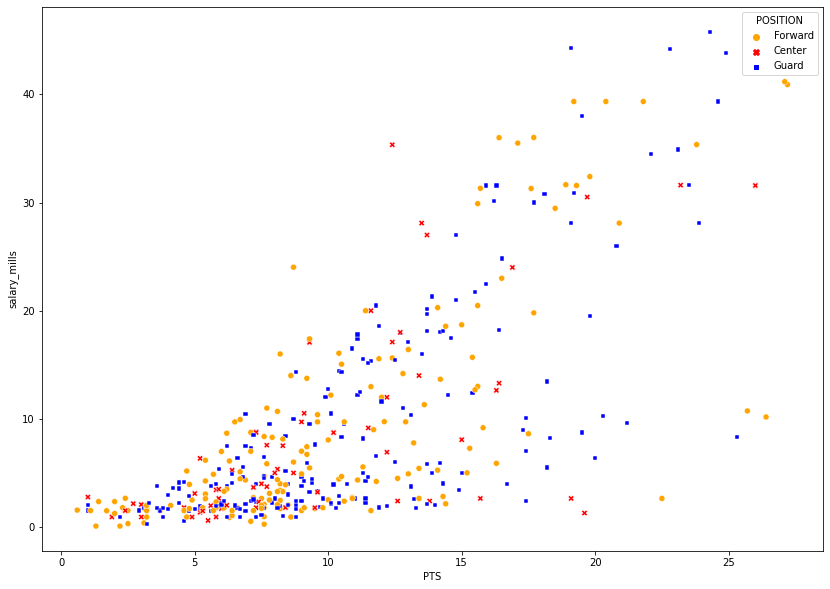

In [ ]:
working_df["salary_mills"] = working_df["SALARY"]/10**6

fig = plt.gcf()
fig.set_size_inches(14, 10)
sns.scatterplot(data=working_df, y="salary_mills", x="PTS", hue="POSITION", style="POSITION", palette = {"Forward": "orange", "Guard":"blue", "Center": "red"})
plt.ticklabel_format(style='plain', axis='x')

## 3.3- Plot assists-vs-salary and rebounding-vs-salary

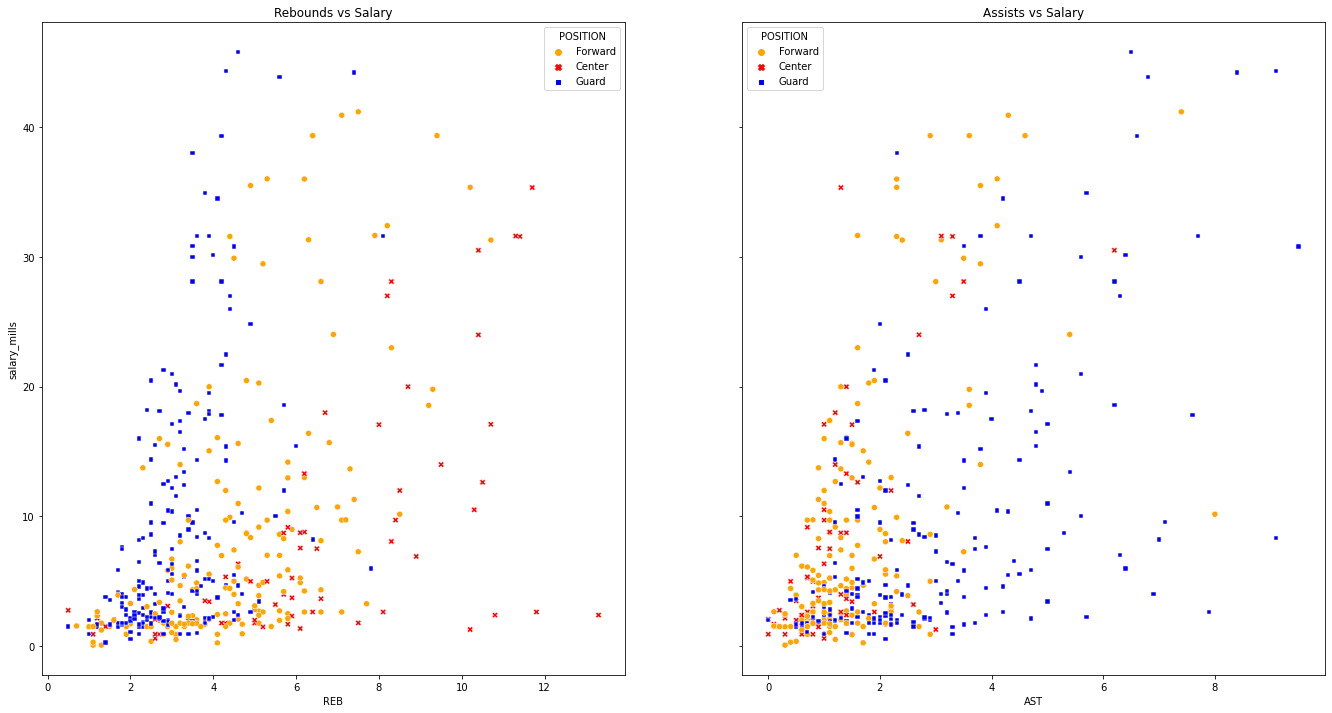

In [ ]:
dicci = {"REB":"Rebounds", "AST":"Assists"}
fig, ax = plt.subplots(1, len(dicci), figsize=(23, 12), sharey=True)
for i,col in enumerate(dicci):
  sns.scatterplot(data=working_df, y="salary_mills", x=col, hue="POSITION", style="POSITION", palette = {"Forward": "orange", "Guard":"blue", "Center": "red"}, \
                  ax=ax[i]).set_title(f"{dicci[col]} vs Salary")

3.4- When NBA players enter the league they have low value salaries during their rookie contract, regardless of how they perform. Lets plot points, assists and rebounding vs salary, but only for players that have more than 4 years of experience (the typical length of a rookie contract).

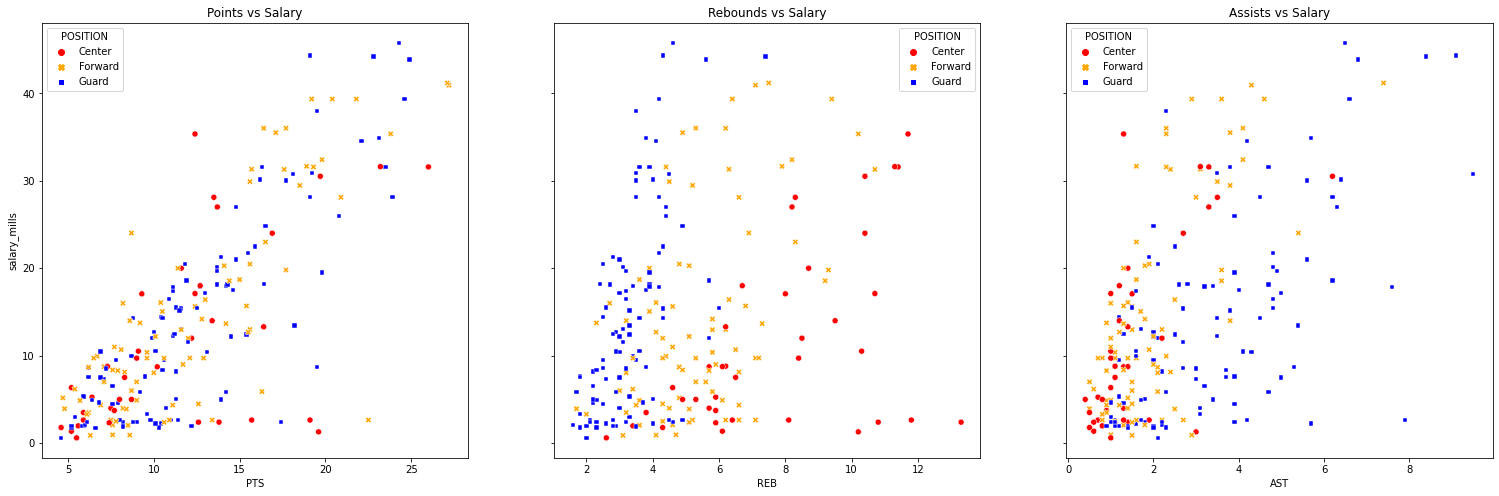

In [ ]:
df=working_df.loc[working_df.SEASON_EXP>4]
dicci = {"PTS":"Points", "REB":"Rebounds", "AST":"Assists"}

fig, ax = plt.subplots(1, len(dicci), figsize=(26, 8), sharey=True)
for i,col in enumerate(dicci):
  sns.scatterplot(data=df, y="salary_mills", x=col, hue="POSITION", style="POSITION", palette = {"Forward": "orange", "Guard":"blue", "Center": "red"}, \
                  ax=ax[i]).set_title(f"{dicci[col]} vs Salary")

3.5- Plot the scoring average grouped by position, we want to be able to see median, quartiles, etc 

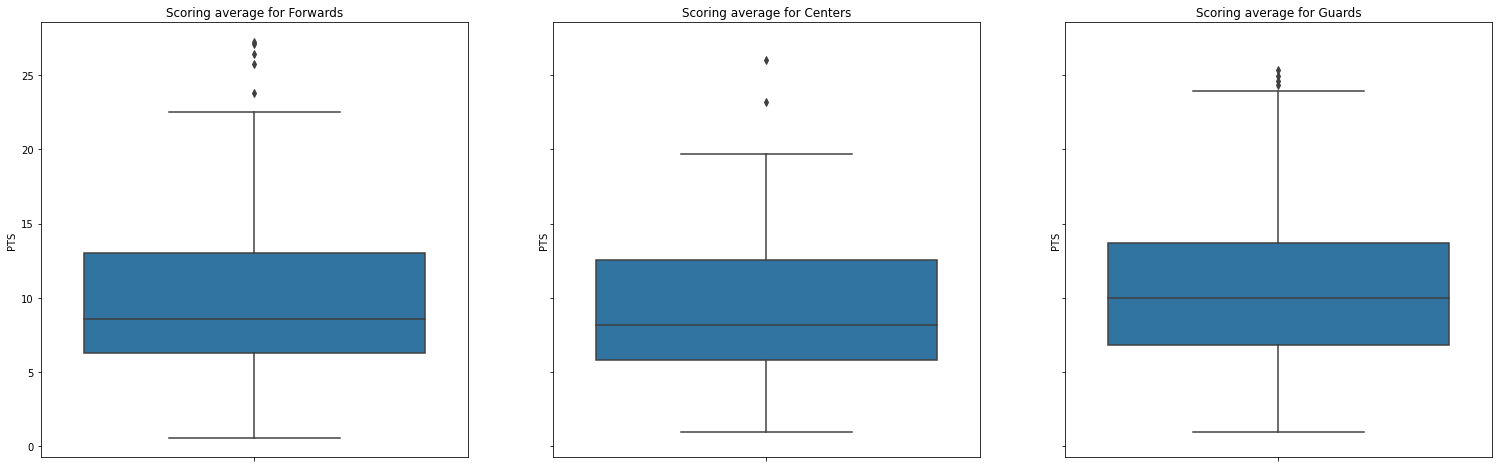

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(26, 8), sharey=True)
for i,col in enumerate(working_df.POSITION.unique()):
  sns.boxplot(data=working_df.loc[working_df.POSITION==col], y="PTS", ax=ax[i]).set_title(f"Scoring average for {col}s")

3.6- Plot the Height distribution of all players

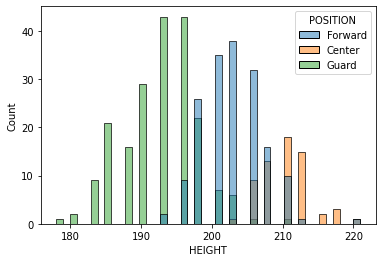

In [ ]:
sns.histplot(data=working_df, x="HEIGHT",  hue = "POSITION", bins=1+working_df.HEIGHT.max() - working_df.HEIGHT.min())

OPTIONAL: Can you find a way to draw a world map and show how many active players per country the NBA has? [Example](https://i.redd.it/8qymui9fnin71.jpg)

In [ ]:
# We create this geodataframe
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

print("The following countries appear differently named on each dataset.")
for coco in working_df.COUNTRY.unique() :
  if coco not in df_world.name.unique():
    print(coco)

# we create an auxiliary column to fix that.
def translator(x):
  dicci = {"USA": 'United States of America',
           "DRC": 'Dem. Rep. Congo',
           "Dominican Republic": 'Dominican Rep.',
           "Republic of the Congo" : 'Congo',
           "Czech Republic": 'Czechia',
           "Bosnia and Herzegovina": 'Bosnia and Herz.'
           }
  if x in dicci:
    return dicci[x]
  else:
    return x

working_df["paises"] = working_df.COUNTRY.apply(translator)

countries_dict = working_df.paises.value_counts().to_dict()
df_world["players"] = df_world.name.map(countries_dict) 

nba_world = df_world.loc[df_world.name.isin(countries_dict)]
nba_world["centroid"] = nba_world.centroid

# I did not find Saint Lucia in the df_world countries list.
working_df.loc[working_df.COUNTRY=="Saint Lucia"]

The following countries appear differently named on each dataset.
USA
DRC
Saint Lucia
Dominican Republic
Republic of the Congo
Czech Republic
Bosnia and Herzegovina


,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE,paises
1628449,Chris Boucher,Raptors,Forward,206,91,Saint Lucia,1993-01-11,5,NaN,231,17.9,9.0,5.3,0.5,0.5,1.2,7009615,"29 years, 8 months, 4 days",Saint Lucia


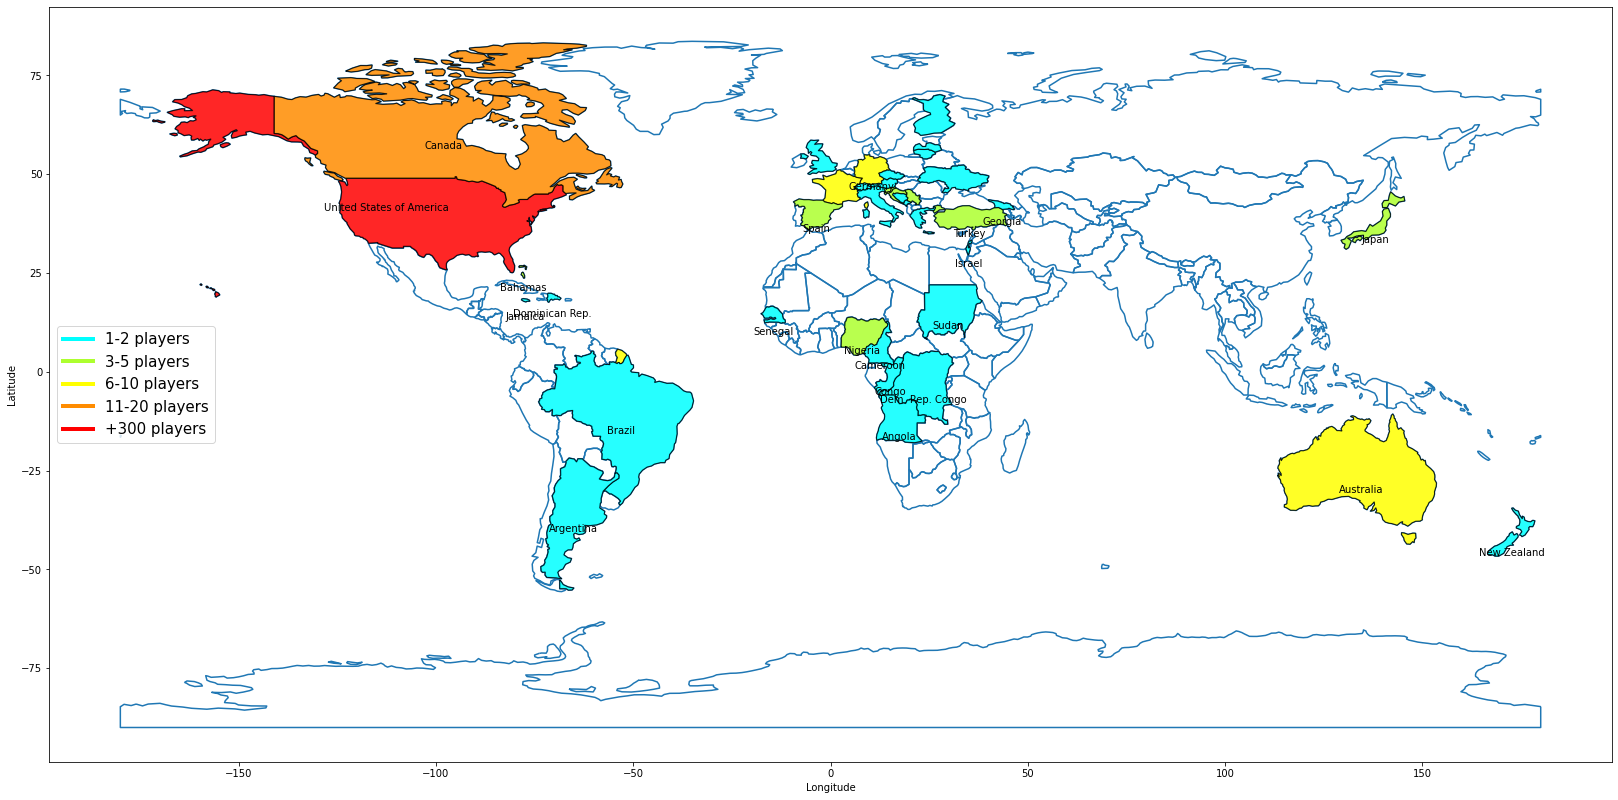

In [ ]:
def plotCountryPatch( axes, country_name, fcolor ):
    nami = df_world[df_world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], 'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

def colorea(n):
  if n < 3:
    return "cyan"
  elif n < 6:
    return "greenyellow"
  elif n < 11:
    return "yellow"
  elif n < 21:
    return "darkorange"
  else:
    return "red"

ax2 = df_world["geometry"].boundary.plot(figsize=(28,19))

for coco in countries_dict:
  if coco != "Saint Lucia":
    plotCountryPatch(ax2, coco, colorea(countries_dict[coco]))

plt.ylabel('Latitude')
plt.xlabel('Longitude')
custom_lines = [Line2D([0], [0], color="cyan", lw=4),
                Line2D([0], [0], color="greenyellow", lw=4),
                Line2D([0], [0], color="yellow", lw=4),
                Line2D([0], [0], color="darkorange", lw=4),
                Line2D([0], [0], color="red", lw=4)
               ]

ax2.legend(custom_lines, ['1-2 players', '3-5 players', '6-10 players', "11-20 players", "+300 players"], loc = "center left", fontsize=15)

for fila in nba_world.itertuples():
  if fila.continent!="Europe" or fila.name in ["Spain", "Germany"]:
    y=fila.centroid
    ax2.annotate(s=fila.name, xy=(y.coords[0][0],y.coords[0][1]-5), ha='center')

plt.show()